#Prediction based on Linear SVM with average at sample level

In [12]:
import pickle
import scipy
import scipy.io
import os
import numpy as np
import scanpy as sc
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import scanpy as sc
import sklearn.model_selection as sks
import numpy as np
import pandas as pd
from sklearn import svm
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import sklearn.metrics as skm
from itertools import cycle
from sklearn.ensemble import RandomForestClassifier
import matplotlib.gridspec as gridspec
import matplotlib.colors as clr
from matplotlib.ticker import MaxNLocator
import random
import collections
from sklearn.model_selection import KFold
import copy
import math
import scipy
import torch
import datetime
import os
import logging.config
import traceback
import random
import numpy as np
import time
import pathlib
import seaborn as sns
import pickle
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import KFold
import collections
import numpy as np
import sklearn.mixture
import math
import logging
import pickle
import sys


In [13]:
    logger = logging.getLogger(__name__)


In [29]:
def train(Xtrain, centers=2,seed=0):
    gm = collections.defaultdict(list)
    for (i, (X, y, *_)) in enumerate(Xtrain):
        model = sklearn.mixture.GaussianMixture(min(centers, X.shape[0]),random_state=seed)
#         print(len(X))
        model.fit(X)
        gm[y].append(model)
    
#         print("Train " + str(i + 1) + " / " + str(len(Xtrain)), end="\r")
        sys.stdout.flush()
#     print()
    return gm

def eval(gm, Xtest):
    total = 0.
    correct = 0
    prob = 0.
    y_score = []
    y_true = []
    pred_=[]
    for (i, (X, y, *_)) in enumerate(Xtest):
        logp = {}
        x = -float("inf")
        for state in gm:
            logp[state] = list(map(lambda m: sum(m.score_samples(X)), gm[state]))
            x = max(x, max(logp[state]))
        # print(logp)
        Z = 0
        for state in logp:
            logp[state] = sum(map(lambda lp: math.exp(lp - x), logp[state]))
            Z += logp[state]
        pred = None
        for state in logp:
            logp[state] /= Z
            if pred is None or logp[state] > logp[pred]:
                pred = state
        total += -math.log(max(1e-50, logp[y]))
        pred_.append(pred)
        correct += (pred == y)
        prob += logp[y]
        y_score.append(logp[1])
        y_true.append(y)
    
#         print("Test " + str(i + 1) + " / " + str(len(Xtest)) + ": " + str(correct / float(i + 1)), end="\r", flush=True)
#     print()
    
    n = len(Xtest)
    res = {}
    res["ce"] = total / float(n)
    res["accuracy"] = correct / float(n)
    res["soft"] = prob / float(n)
    res["auc"] = sklearn.metrics.roc_auc_score(y_true, y_score)

    logger = logging.getLogger(__name__)
    logger.debug("        Genpat Cross-entropy: " + str(res["ce"]))
    logger.debug("        Genpat Accuracy:      " + str(res["accuracy"]))
    logger.debug("        Genpat Soft Accuracy: " + str(res["soft"]))
    logger.debug("        Genpat AUC:           " + str(res["auc"]))
#     with open(args.dir+'/y_score_genpat', 'wb') as fp:
#                             pickle.dump(y_score, fp)
#     with open(args.dir+'/pred_genpat', 'wb') as fp:
#                             pickle.dump(pred_, fp)  
#     with open(args.dir+'/y_true_genpat', 'wb') as fp:
#                             pickle.dump(y_true, fp)    
    return res


In [15]:
with open("../../2cohorts/chr2chr1/Xtest__.pkl", "rb") as f:
                Xtest = pickle.load(f)
with open("../../2cohorts/chr2chr1/Xall.pkl", "rb") as f:
                Xall = pickle.load(f)
with open("../../2cohorts/chr2chr1/Ctest__.pkl", "rb") as f:
                adata1_c = pickle.load(f)
with open("../../2cohorts/chr2chr1/Call__.pkl", "rb") as f:
                adata_c = pickle.load(f)
                

In [16]:
Xtrain=np.concatenate([Xall[0],Xall[1]])


## Load marker genes obtanined using seurat code

### Markers from the published paper

In [17]:
# markers = ['HLA-DRA','HLA-DRB1','LYZ','CST3','TYROBP','AP1S2','CSTA','FCN1','MS4A6A','LST1','CYBB','CTSS','DUSP6','IL1B','SGK1','KLF4','CLEC7A','ATP2B1-AS1','MARCKS',
# 'SAT1','MYADM','IFI27','IFITM3','ISG15','APOBEC3A','IFI6','TNFSF10','MT2A','MX1','IFIT3','MNDA','S100A12','S100A9','S100A8','MAFB','VCAN','PLBD1','CXCL8',
# 'RNASE2','FCGR3A','MS4A7','CDKN1C','AIF1','COTL1','FCER1G','C1QA','RHOC','FCGR3B','IFITM2','NAMPT','G0S2','PROK2','CMTM2',
# 'BASP1','BCL2A1','SLC25A37','DEFA3','LTF','LCN2','CAMP','RETN','DEFA4','CD24','PGLYRP1','OLFM4']

# Input formating for the prediction 

In [18]:
            df= pd.read_csv('../scripts/marker_cohort2')
            df["avg_log2FC"] = np.abs(df["avg_log2FC"])
            df = df.loc[df["cluster"].isin([7,11,3,4,6]),:]
            feat_tab = df.groupby('cluster')
            df2= feat_tab.apply(lambda x: x.sort_values(["avg_log2FC"], ascending=False)).reset_index(drop=True)
            feat=df2.groupby('cluster').head(50)
            idx_te= np.where(adata1_c.isin (feat.gene.values))[0] 
            idx_tr= np.where(adata_c.isin (adata1_c[idx_te]))[0]            

#             markers = ['HLA-DRA','HLA-DRB1','LYZ','CST3','TYROBP','AP1S2','CSTA','FCN1','MS4A6A','LST1','CYBB','CTSS','DUSP6','IL1B','SGK1','KLF4','CLEC7A','ATP2B1-AS1','MARCKS','SAT1','MYADM','IFI27','IFITM3','ISG15','APOBEC3A','IFI6','TNFSF10','MT2A','MX1','IFIT3','MNDA','S100A12','S100A9','S100A8','MAFB','VCAN','PLBD1','CXCL8','RNASE2','FCGR3A','MS4A7','CDKN1C','AIF1','COTL1','FCER1G','C1QA','RHOC','FCGR3B','IFITM2','NAMPT','G0S2','PROK2','CMTM2','BASP1','BCL2A1','SLC25A37','DEFA3','LTF','LCN2','CAMP','RETN','DEFA4','CD24','PGLYRP1','OLFM4']
#             idx_tr= np.where(adata_c.isin (markers))[0]
#             idx_te= np.where(adata1_c.isin (markers))[0]

            Xtrain = list(map(lambda x: (x[0][:,idx_tr], *x[1:]), Xtrain))
            Xtest = list(map(lambda x: (x[0][:,idx_te], *x[1:]), Xtest))
            Xtrain = list(map(lambda x: (x[0].todense(), *x[1:]), Xtrain))
            Xtest  = list(map(lambda x: (x[0].todense(), *x[1:]), Xtest))

# SVM

In [19]:
X_train= Xtrain


In [24]:
for seed in [0,42,10,1234,4321]:
    print("start generative")
    best_model = None
    best_score = -float("inf")
    for centers in [5]:
                    kf = KFold(n_splits=5, shuffle= True, random_state=seed).split(X_train)
                    for elem in kf:
                        train_index, test_index=elem
                        Xtrain, Xvalid = list(np.array(X_train)[train_index]), list(np.array(X_train)[test_index])
                        print(len(Xvalid))
                        model = train(Xtrain, centers,seed)
                        logger.debug("    Training:")
                        res = eval(model, Xtrain)
                        logger.debug("    Validation")
                        res = eval(model, Xvalid)

                        if (res["accuracy"] > best_score) or (res["accuracy"] == best_score and res["auc"] > best_score_auc):
                            best_model = model
                            best_score = res["accuracy"]
                            best_score_auc = res["auc"]
                            res_=res
                            best_centers = centers

    # with open(args.dir+'/generative', 'wb') as fp:
    #                  pickle.dump(best_model, fp)             
    print(res_)
    res =eval(best_model, Xtest)
    print(res)

start generative
10
292
436in 1 / 40
950in 2 / 40
830in 3 / 40
1033n 4 / 40
341in 5 / 40
754in 6 / 40
327in 7 / 40
670in 8 / 40
663in 9 / 40
379in 10 / 40
431in 11 / 40
310in 12 / 40
487in 13 / 40
232in 14 / 40
354in 15 / 40
169in 16 / 40
426in 17 / 40
880in 18 / 40
1192n 19 / 40
256in 20 / 40
226in 21 / 40
624in 22 / 40
800in 23 / 40
547in 24 / 40
495in 25 / 40
568in 26 / 40
331in 27 / 40
327in 28 / 40
1649n 29 / 40
2572n 30 / 40
4732n 31 / 40
191in 32 / 40
1526n 33 / 40
3652n 34 / 40
377in 35 / 40
158in 36 / 40
20ain 37 / 40
1889n 38 / 40
351in 39 / 40
Train 40 / 40
Test 40 / 40: 1.0
Test 10 / 10: 0.5444444444444446
10
292
436in 1 / 40
289in 2 / 40
950in 3 / 40
1727n 4 / 40
830in 5 / 40
1033n 6 / 40
754in 7 / 40
327in 8 / 40
629in 9 / 40
284in 10 / 40
670in 11 / 40
663in 12 / 40
431in 13 / 40
310in 14 / 40
487in 15 / 40
354in 16 / 40
169in 17 / 40
426in 18 / 40
1525n 19 / 40
880in 20 / 40
1192n 21 / 40
256in 22 / 40
94ain 23 / 40
503in 24 / 40
800in 25 / 40
791in 26 / 40
547in 27 / 4

56ain 32 / 40
191in 33 / 40
1526n 34 / 40
3652n 35 / 40
158in 36 / 40
20ain 37 / 40
1889n 38 / 40
351in 39 / 40
Train 40 / 40
Test 40 / 40: 1.0
Test 10 / 10: 0.211111111111111
10
292
436in 1 / 40
289in 2 / 40
950in 3 / 40
830in 4 / 40
1033n 5 / 40
341in 6 / 40
754in 7 / 40
327in 8 / 40
629in 9 / 40
670in 10 / 40
663in 11 / 40
431in 12 / 40
487in 13 / 40
232in 14 / 40
354in 15 / 40
169in 16 / 40
426in 17 / 40
1525n 18 / 40
880in 19 / 40
256in 20 / 40
226in 21 / 40
94ain 22 / 40
503in 23 / 40
624in 24 / 40
800in 25 / 40
791in 26 / 40
547in 27 / 40
568in 28 / 40
331in 29 / 40
327in 30 / 40
1649n 31 / 40
2572n 32 / 40
4732n 33 / 40
191in 34 / 40
1526n 35 / 40
3652n 36 / 40
377in 37 / 40
20ain 38 / 40
351in 39 / 40
Train 40 / 40
Test 40 / 40: 1.0
Test 10 / 10: 0.5444444444444446
10
436
289in 1 / 40
950in 2 / 40
1727n 3 / 40
830in 4 / 40
1033n 5 / 40
341in 6 / 40
629in 7 / 40
284in 8 / 40
670in 9 / 40
663in 10 / 40
379in 11 / 40
310in 12 / 40
487in 13 / 40
232in 14 / 40
354in 15 / 40
169in 1

In [26]:
best_score_auc

0.7619047619047621

### prediction on 25% of cohort2

In [27]:
with open("../../2cohorts/chr2chr1/Xtest__.pkl", "rb") as f:
                Xtest = pickle.load(f)
with open("../../2cohorts/chr2chr1/Xall.pkl", "rb") as f:
                Xall = pickle.load(f)
with open("../../2cohorts/chr2chr1/Ctest__.pkl", "rb") as f:
                adata1_c = pickle.load(f)
with open("../../2cohorts/chr2chr1/Call__.pkl", "rb") as f:
                adata_c = pickle.load(f)
                
Xtrain=np.concatenate([Xall[0],Xall[1]])
            
df= pd.read_csv('../scripts/marker_cohort2')
df["avg_log2FC"] = np.abs(df["avg_log2FC"])
df = df.loc[df["cluster"].isin([7,11,3,4,6]),:]
feat_tab = df.groupby('cluster')
df2= feat_tab.apply(lambda x: x.sort_values(["avg_log2FC"], ascending=False)).reset_index(drop=True)
feat=df2.groupby('cluster').head(20)
idx_te= np.where(adata1_c.isin (feat.gene.values))[0] 
idx_tr= np.where(adata_c.isin (adata1_c[idx_te]))[0]            

#             markers = ['HLA-DRA','HLA-DRB1','LYZ','CST3','TYROBP','AP1S2','CSTA','FCN1','MS4A6A','LST1','CYBB','CTSS','DUSP6','IL1B','SGK1','KLF4','CLEC7A','ATP2B1-AS1','MARCKS','SAT1','MYADM','IFI27','IFITM3','ISG15','APOBEC3A','IFI6','TNFSF10','MT2A','MX1','IFIT3','MNDA','S100A12','S100A9','S100A8','MAFB','VCAN','PLBD1','CXCL8','RNASE2','FCGR3A','MS4A7','CDKN1C','AIF1','COTL1','FCER1G','C1QA','RHOC','FCGR3B','IFITM2','NAMPT','G0S2','PROK2','CMTM2','BASP1','BCL2A1','SLC25A37','DEFA3','LTF','LCN2','CAMP','RETN','DEFA4','CD24','PGLYRP1','OLFM4']
#             idx_tr= np.where(adata_c.isin (markers))[0]
#             idx_te= np.where(adata1_c.isin (markers))[0]

Xtrain = list(map(lambda x: (x[0][:,idx_tr], *x[1:]), Xtrain))
Xtest = list(map(lambda x: (x[0][:,idx_te], *x[1:]), Xtest))
Xtrain = list(map(lambda x: (x[0].todense(), *x[1:]), Xtrain))
Xtest  = list(map(lambda x: (x[0].todense(), *x[1:]), Xtest))
X_train= Xtrain


### Extract prediction at sample level

In [28]:
for seed in [0,42,10,1234,4321]:
    print("start generative")
    best_model = None
    best_score = -float("inf")
    for centers in [5]:
                    kf = KFold(n_splits=5, shuffle= True, random_state=seed).split(X_train)
                    for elem in kf:
                        train_index, test_index=elem
                        Xtrain, Xvalid = list(np.array(X_train)[train_index]), list(np.array(X_train)[test_index])
                        print(len(Xvalid))
                        model = train(Xtrain, centers,seed)
                        logger.debug("    Training:")
                        res = eval(model, Xtrain)
                        logger.debug("    Validation")
                        res = eval(model, Xvalid)

                        if (res["accuracy"] > best_score) or (res["accuracy"] == best_score and res["auc"] > best_score_auc):
                            best_model = model
                            best_score = res["accuracy"]
                            best_score_auc = res["auc"]
                            res_=res
                            best_centers = centers

    # with open(args.dir+'/generative', 'wb') as fp:
    #                  pickle.dump(best_model, fp)             
    print(res_)
    res =eval(best_model, Xtest)
    print(res)

start generative
10
292
436
950
830
1033
341
754
327
670
663
379
431
310
487
232
354
169
426
880
1192
256
226
624
800
547
495
568
331
327
1649
2572
4732
191
1526
3652
377
158
20
1889
351
10
292
436
289
950
1727
830
1033
754
327
629
284
670
663
431
310
487
354
169
426
1525
880
1192
256
94
503
800
791
547
327
1649
354
2572
4732
56
191
1526
3652
158
20
351
10
292
436
289
950
1727
830
1033
341
327
629
284
670
379
487
232
354
426
1525
880
1192
226
94
503
624
791
495
568
331
327
1649
354
2572
4732
56
3652
377
158
20
1889
351
10
292
289
950
1727
341
754
327
629
284
663
379
431
310
232
354
169
426
1525
256
226
94
503
624
800
791
547
495
568
331
327
354
2572
56
191
1526
3652
377
158
20
1889
10
436
289
1727
830
1033
341
754
629
284
670
663
379
431
310
487
232
169
1525
880
1192
256
226
94
503
624
800
791
547
495
568
331
1649
354
4732
56
191
1526
377
1889
351
{'ce': 34.53877639491069, 'accuracy': 0.7, 'soft': 0.7, 'auc': 0.5}
{'ce': 55.432604090597394, 'accuracy': 0.5185185185185185, 'soft': 0.518

### AUC

In [30]:
with open("../../2cohorts/chr2chr1/Xtest__.pkl", "rb") as f:
                Xtest = pickle.load(f)
with open("../../2cohorts/chr2chr1/Xall.pkl", "rb") as f:
                Xall = pickle.load(f)
with open("../../2cohorts/chr2chr1/Ctest__.pkl", "rb") as f:
                adata1_c = pickle.load(f)
with open("../../2cohorts/chr2chr1/Call__.pkl", "rb") as f:
                adata_c = pickle.load(f)
                
Xtrain=np.concatenate([Xall[0],Xall[1]])
            
df= pd.read_csv('../scripts/marker_cohort2')
df["avg_log2FC"] = np.abs(df["avg_log2FC"])
df = df.loc[df["cluster"].isin([7,11,3,4,6]),:]
feat_tab = df.groupby('cluster')
df2= feat_tab.apply(lambda x: x.sort_values(["avg_log2FC"], ascending=False)).reset_index(drop=True)
feat=df2.groupby('cluster').head(100)
idx_te= np.where(adata1_c.isin (feat.gene.values))[0] 
idx_tr= np.where(adata_c.isin (adata1_c[idx_te]))[0]            

#             markers = ['HLA-DRA','HLA-DRB1','LYZ','CST3','TYROBP','AP1S2','CSTA','FCN1','MS4A6A','LST1','CYBB','CTSS','DUSP6','IL1B','SGK1','KLF4','CLEC7A','ATP2B1-AS1','MARCKS','SAT1','MYADM','IFI27','IFITM3','ISG15','APOBEC3A','IFI6','TNFSF10','MT2A','MX1','IFIT3','MNDA','S100A12','S100A9','S100A8','MAFB','VCAN','PLBD1','CXCL8','RNASE2','FCGR3A','MS4A7','CDKN1C','AIF1','COTL1','FCER1G','C1QA','RHOC','FCGR3B','IFITM2','NAMPT','G0S2','PROK2','CMTM2','BASP1','BCL2A1','SLC25A37','DEFA3','LTF','LCN2','CAMP','RETN','DEFA4','CD24','PGLYRP1','OLFM4']
#             idx_tr= np.where(adata_c.isin (markers))[0]
#             idx_te= np.where(adata1_c.isin (markers))[0]

Xtrain = list(map(lambda x: (x[0][:,idx_tr], *x[1:]), Xtrain))
Xtest = list(map(lambda x: (x[0][:,idx_te], *x[1:]), Xtest))
Xtrain = list(map(lambda x: (x[0].todense(), *x[1:]), Xtrain))
Xtest  = list(map(lambda x: (x[0].todense(), *x[1:]), Xtest))
X_train= Xtrain


In [31]:
for seed in [0,42,10,1234,4321]:
    print("start generative")
    best_model = None
    best_score = -float("inf")
    for centers in [5]:
                    kf = KFold(n_splits=5, shuffle= True, random_state=seed).split(X_train)
                    for elem in kf:
                        train_index, test_index=elem
                        Xtrain, Xvalid = list(np.array(X_train)[train_index]), list(np.array(X_train)[test_index])
                        print(len(Xvalid))
                        model = train(Xtrain, centers,seed)
                        logger.debug("    Training:")
                        res = eval(model, Xtrain)
                        logger.debug("    Validation")
                        res = eval(model, Xvalid)

                        if (res["accuracy"] > best_score) or (res["accuracy"] == best_score and res["auc"] > best_score_auc):
                            best_model = model
                            best_score = res["accuracy"]
                            best_score_auc = res["auc"]
                            res_=res
                            best_centers = centers

    # with open(args.dir+'/generative', 'wb') as fp:
    #                  pickle.dump(best_model, fp)             
    print(res_)
    res =eval(best_model, Xtest)
    print(res)

start generative
10
10
10
10
10
{'ce': 46.051701859880914, 'accuracy': 0.6, 'soft': 0.6, 'auc': 0.6}
{'ce': 59.69665055910488, 'accuracy': 0.48148148148148145, 'soft': 0.48148148148148145, 'auc': 0.5}
start generative
10
10
10
10
10
{'ce': 34.53877639491069, 'accuracy': 0.7, 'soft': 0.7, 'auc': 0.5}
{'ce': 89.54497583865735, 'accuracy': 0.2222222222222222, 'soft': 0.2222222222222222, 'auc': 0.22252747252747251}
start generative
10
10
10
10
10
{'ce': 23.025850929940457, 'accuracy': 0.8, 'soft': 0.8, 'auc': 0.8}
{'ce': 55.432604090597394, 'accuracy': 0.5185185185185185, 'soft': 0.5185185185185185, 'auc': 0.5}
start generative
10
10
10
10
10
{'ce': 34.53877639491069, 'accuracy': 0.7, 'soft': 0.7, 'auc': 0.5}
{'ce': 89.54497583865735, 'accuracy': 0.2222222222222222, 'soft': 0.2222222222222222, 'auc': 0.21978021978021978}
start generative
10
10
10
10
10
{'ce': 34.53877639491069, 'accuracy': 0.7, 'soft': 0.7, 'auc': 0.625}
{'ce': 51.1685576220899, 'accuracy': 0.5555555555555556, 'soft': 0.55

# Test on Cohort1

In [ ]:
with open("../../2cohorts

In [130]:
with open("../../2cohorts_markers/chr2chr1/Xtest__.pkl", "rb") as f:
                Xtest = pickle.load(f)
with open("../../2cohorts_markers/chr2chr1/Xall.pkl", "rb") as f:
                Xall = pickle.load(f)
with open("../../2cohorts_markers/chr2chr1/Ctest__.pkl", "rb") as f:
                adata1_c = pickle.load(f)
with open("../../2cohorts_markers/chr2chr1/Call__.pkl", "rb") as f:
                adata_c = pickle.load(f)
                
Xtrain=np.concatenate([Xall[0],Xall[1]])
            
df= pd.read_csv('../scripts/marker_cohort2')
df["avg_log2FC"] = np.abs(df["avg_log2FC"])
# df = df.loc[df["cluster"].isin([7,11,3,4,6]),:]
feat_tab = df.groupby('cluster')
df2= feat_tab.apply(lambda x: x.sort_values(["avg_log2FC"], ascending=False)).reset_index(drop=True)
feat=df2.groupby('cluster').head(20)
idx_te= np.where(adata1_c.isin (feat.gene.values))[0] 
idx_tr= np.where(adata_c.isin (adata1_c[idx_te]))[0]            

#             markers = ['HLA-DRA','HLA-DRB1','LYZ','CST3','TYROBP','AP1S2','CSTA','FCN1','MS4A6A','LST1','CYBB','CTSS','DUSP6','IL1B','SGK1','KLF4','CLEC7A','ATP2B1-AS1','MARCKS','SAT1','MYADM','IFI27','IFITM3','ISG15','APOBEC3A','IFI6','TNFSF10','MT2A','MX1','IFIT3','MNDA','S100A12','S100A9','S100A8','MAFB','VCAN','PLBD1','CXCL8','RNASE2','FCGR3A','MS4A7','CDKN1C','AIF1','COTL1','FCER1G','C1QA','RHOC','FCGR3B','IFITM2','NAMPT','G0S2','PROK2','CMTM2','BASP1','BCL2A1','SLC25A37','DEFA3','LTF','LCN2','CAMP','RETN','DEFA4','CD24','PGLYRP1','OLFM4']
#             idx_tr= np.where(adata_c.isin (markers))[0]
#             idx_te= np.where(adata1_c.isin (markers))[0]

Xtrain = list(map(lambda x: (x[0][:,idx_tr], *x[1:]), Xtrain))
Xtest = list(map(lambda x: (x[0][:,idx_te], *x[1:]), Xtest))
Xtrain = list(map(lambda x: (x[0].todense(), *x[1:]), Xtrain))
Xtest  = list(map(lambda x: (x[0].todense(), *x[1:]), Xtest))
X_train= Xtrain


In [ ]:
for seed in [0,42,10,1234,4321]:
    print("start generative")
    best_model = None
    best_score = -float("inf")
    for centers in [5]:
                    kf = KFold(n_splits=5, shuffle= True, random_state=seed).split(X_train)
                    for elem in kf:
                        train_index, test_index=elem
                        Xtrain, Xvalid = list(np.array(X_train)[train_index]), list(np.array(X_train)[test_index])
                        print(len(Xvalid))
                        model = train(Xtrain, centers,seed)
                        logger.debug("    Training:")
                        res = eval(model, Xtrain)
                        logger.debug("    Validation")
                        res = eval(model, Xvalid)

                        if (res["accuracy"] > best_score) or (res["accuracy"] == best_score and res["auc"] > best_score_auc):
                            best_model = model
                            best_score = res["accuracy"]
                            best_score_auc = res["auc"]
                            res_=res
                            best_centers = centers

    # with open(args.dir+'/generative', 'wb') as fp:
    #                  pickle.dump(best_model, fp)             
    print(res_)
    res =eval(best_model, Xtest)
    print(res)

start generative
10
10
10
10
10
{'accuracy': 0.9, 'soft': 0.9, 'auc': 0.8400000000000001}
{'accuracy': 0.8518518518518519, 'soft': 0.8518518518518519, 'auc': 0.956043956043956}
start generative
10
10
10
10
10
{'accuracy': 0.9, 'soft': 0.9, 'auc': 0.9600000000000001}
{'accuracy': 0.48148148148148145, 'soft': 0.48148148148148145, 'auc': 0.04945054945054943}
start generative
10
10
10


In [147]:
pred_agg2=[]
y_t2=[]
for ii in range(len(count_test2_s)):
    if ii ==0:
        pred_agg2.append(np.mean(pred2[:count_test2_s[ii]]))
        y_t2.append(np.mean(y_true2[:count_test2_s[ii]]))
    else:
        iiii=ii-1
        iii = sum(count_test2_s[:ii])
        pred_agg2.append(np.mean(pred2[iii:iii+count_test2_s[ii]]))
        y_t2.append(np.mean(y_true2[iii:iii+count_test2_s[ii]]))


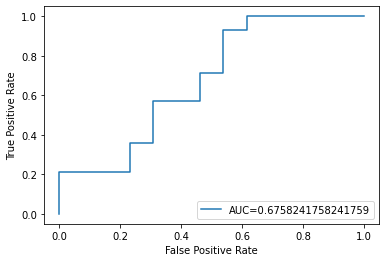

In [148]:
    classes_=[0,1]
    fpr, tpr, _ = skm.roc_curve(y_t2,  pred_agg2)
    auc = skm.roc_auc_score(y_t2,  pred_agg2)
    #create ROC curve
    plt.plot(fpr,tpr,label="AUC="+str(auc))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()